**Общая информация**

**Срок сдачи:** 16 марта 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [7]:
import random
import re
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import  fetch_20newsgroups

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KDTree, DistanceMetric
from sklearn.metrics import accuracy_score, pairwise_distances

from scipy.spatial.distance import euclidean

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [14]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm = 'brute', metric = 'euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.n_classes = np.unique(y).shape[0]
        return self
    
    def brute(self,X):
        dist = pairwise_distances(X, self.X_train, metric = self.metric)
        ind = np.argpartition(dist, self.n_neighbors, axis = 1)[:,:self.n_neighbors]
        return np.apply_along_axis(np.bincount,1,self.y_train[ind],
                                   minlength = self.n_classes).argmax(axis=1)
    def kd_tree(self,point):
        X = np.concatenate((point[np.newaxis,:],self.X_train),axis=0)
        tree = KDTree(X, metric = self.metric)
        ind = tree.query(X[:1], k=self.n_neighbors+1, return_distance = False)
        ind = ind.ravel()[1:]-1
        return np.bincount(self.y_train[ind]).argmax()
    
    def predict(self, X):
        if self.algorithm == 'brute':
            return self.brute(X)
        elif self.algorithm == 'kd_tree':
            return np.apply_along_axis(self.kd_tree, 1, X)   
        
    def score(self,X,y):
        return accuracy_score(y,self.predict(X))

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 4.4 ms, sys: 0 ns, total: 4.4 ms
Wall time: 2.74 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 53 µs, sys: 11 µs, total: 64 µs
Wall time: 66.3 µs


MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=2)

In [10]:
%time clf.predict(X_test)

CPU times: user 8.57 ms, sys: 0 ns, total: 8.57 ms
Wall time: 5.83 ms


array([1, 0, 0, 1, 2, 1, 1, 2, 2, 0, 0, 2, 0, 1, 2])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 1.09 ms, sys: 220 µs, total: 1.31 ms
Wall time: 880 µs


array([1, 0, 0, 1, 2, 1, 1, 2, 2, 0, 0, 2, 0, 1, 2])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 1.6 ms, sys: 323 µs, total: 1.92 ms
Wall time: 4.97 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 320 µs, sys: 65 µs, total: 385 µs
Wall time: 257 µs


MyKNeighborsClassifier(algorithm='kd_tree', metric='euclidean', n_neighbors=2)

In [18]:
%time clf.predict(X_test)

CPU times: user 380 µs, sys: 3.25 ms, total: 3.63 ms
Wall time: 2.79 ms


array([1, 0, 2, 1, 1, 0, 0, 2, 2, 0, 2, 0, 1, 1, 2])

In [19]:
%time my_clf.predict(X_test)

CPU times: user 792 µs, sys: 4.05 ms, total: 4.84 ms
Wall time: 3.78 ms


array([1, 0, 2, 1, 1, 0, 0, 2, 2, 0, 2, 0, 1, 1, 2])

In [20]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [140]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [141]:
data_old = newsgroups['data']
target_old = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [142]:
data = [re.sub('\W', ' ', s).lower() for s in data_old
             if len(re.sub('\W', ' ', s).split()) > 0]
target = np.array([tar for s, tar in zip(data_old,target_old) if len(re.sub('\W', ' ', s).split()) > 0])

In [99]:
vectorizer = CountVectorizer(max_df=0.1)
X = vectorizer.fit_transform(data)

In [143]:
random.seed(1448)
ind = list(range(X.shape[0]))
# random.shuffle(ind)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

best k is  1
best score is  0.27617230098146134
all scores is  [0.2761723  0.2348237  0.22446383 0.22473646 0.22564522 0.22101054
 0.21764813 0.21246819 0.20965104 0.20846965]


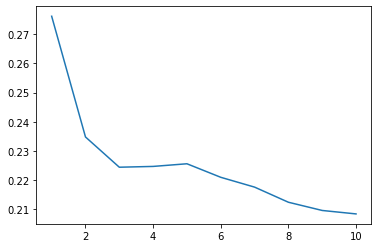

In [101]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1),
                                           X[ind], target[ind], cv = 3)) for k in range(10)]) 
print('best k is ',answer.argmax()+1)
print('best score is ',answer.max())
print('all scores is ',answer)
plt.plot(range(1,11), answer);

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

best k is  10
best score is  0.5936023264267539
all scores is  [0.57179208 0.52526354 0.54916394 0.56215921 0.57251908 0.58242457
 0.58769538 0.59287532 0.59160305 0.59360233]


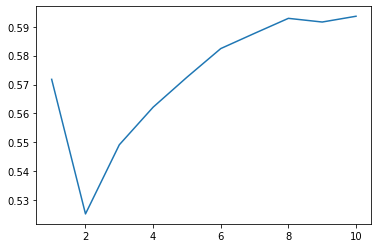

In [102]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1, metric = 'cosine'),
                                           X[ind], target[ind], cv = 3)) for k in range(10)]) 
print('best k is ',answer.argmax()+1)
print('best score is ',answer.max())
print('all scores is ',answer)
plt.plot(range(1,11), answer);

In [103]:
vectorizer = TfidfVectorizer(max_df = 0.1)
X_tfidf = vectorizer.fit_transform(data)

In [104]:
random.seed(1448)
ind = list(range(X_tfidf.shape[0]))
# random.shuffle(ind)

best k is  10
best score is  0.5606143220647036
all scores is  [0.14031261 0.10487096 0.09505634 0.18838604 0.24218466 0.27090149
 0.33442385 0.41812068 0.49291167 0.56061432]


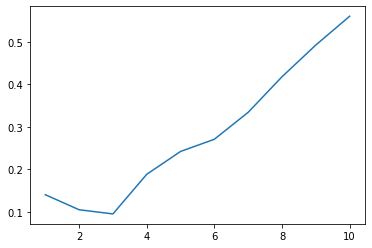

In [105]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1), 
                                           X_tfidf[ind], target[ind], cv = 3)) for k in range(10)])
print('best k is ',answer.argmax()+1)
print('best score is ',answer.max())
print('all scores is ',answer)
plt.plot(range(1,11), answer);

best k is  10
best score is  0.6844783715012722
all scores is  [0.63967648 0.59660124 0.63031625 0.64785533 0.66139586 0.66812068
 0.67384587 0.67893493 0.6824791  0.68447837]


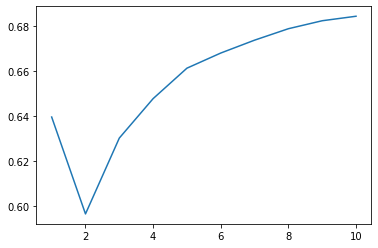

In [106]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1, metric = 'cosine'),
                                           X_tfidf[ind], target[ind], cv = 3)) for k in range(10)]) 

print('best k is ',answer.argmax()+1)
print('best score is ',answer.max())
print('all scores is ',answer)
plt.plot(range(1,11), answer);

Решил посмотреть зависимость скора от ограничения частотности в векторайзарах

In [157]:
def foo(metric, Vectorizer):
    x = np.linspace(0.1,1,10)
    y = []
    best_k = []
    for i in x:
        vectorizer_test = Vectorizer(max_df=i)
        X = vectorizer_test.fit_transform(data)
        answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1, metric = metric),
                                                   X[ind], target[ind], cv = 3)) for k in range(10)]) 
        y.append(answer.max())
        best_k.append(answer.argmax()+1)
    print('best k is ', best_k)
    print('best score is ', y)
        
    plt.plot(x,y)    


best k is  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
best score is  [0.27617230098146134, 0.252271901126863, 0.2478189749182116, 0.24472918938567792, 0.23182479098509634, 0.23446019629225737, 0.22410032715376227, 0.21792075608869502, 0.2122864412940749, 0.2122864412940749]


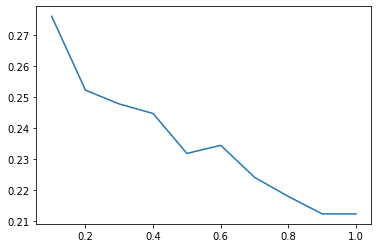

In [159]:
foo('euclidean', CountVectorizer)

best k is  [10, 10, 9, 1, 1, 1, 1, 1, 1, 1]
best score is  [0.5936023264267539, 0.5367139222101054, 0.47428207924391136, 0.4469283896764813, 0.3996728462377317, 0.3842239185750636, 0.3356961105052709, 0.3098873137041076, 0.2986186841148673, 0.2986186841148673]


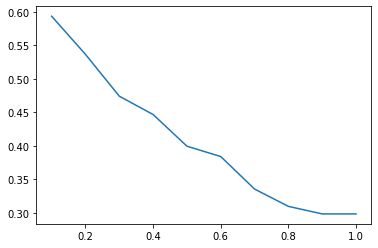

In [160]:
foo('cosine', CountVectorizer)

best k is  [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
best score is  [0.5606143220647036, 0.6594874591057797, 0.6596692111959287, 0.6550345328971283, 0.6470374409305707, 0.6428571428571428, 0.626772082878953, 0.6114140312613595, 0.586423118865867, 0.586423118865867]


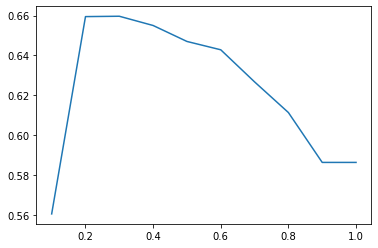

In [162]:
foo('euclidean', TfidfVectorizer)

best k is  [9, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1]
best score is  [0.6808433296982915, 0.6844783715012722, 0.6853871319520174, 0.675118138858597, 0.6752998909487459, 0.6644856415848782, 0.6607597237368229, 0.6594874591057797, 0.6587604507451835, 0.6508542348237004, 0.6508542348237004, 0.6468556888404217, 0.6363140676117776, 0.6333151581243185, 0.6291348600508906, 0.6245910577971647, 0.6245910577971647, 0.6124136677571791, 0.6124136677571791, 0.6124136677571791]


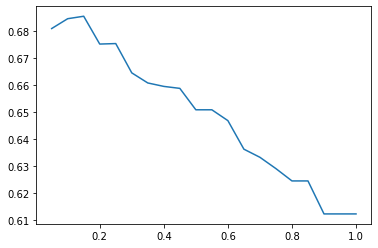

In [154]:
foo('cosine', TfidfVectorizer)

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [8]:
newsgroups_test = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [9]:
data_test_old = newsgroups_test['data']
target_test_old = newsgroups_test['target']

In [10]:
data_test = [re.sub('\W', ' ', s).lower() for s in data_test_old
             if len(re.sub('\W', ' ', s).split()) > 0]
target_test = np.array([tar for s, tar in zip(data_test_old, target_test_old) 
                        if len(re.sub('\W', ' ', s).split()) > 0])

In [11]:
vectorizer_test = TfidfVectorizer(max_df=0.1)
X_test = vectorizer_test.fit_transform(data_test)

In [12]:
random.seed(1448)
ind = list(range(X_test.shape[0]))
# random.shuffle(ind)

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

best k is  10
best score is  0.6632918006674603
all scores is  [0.63346563 0.58243264 0.61212214 0.6249824  0.64536753 0.64536826
 0.65371415 0.65467128 0.65932388 0.6632918 ]


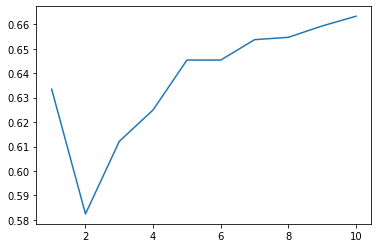

In [16]:
answer = np.array([np.mean(cross_val_score(MyKNeighborsClassifier(n_neighbors=k+1, metric = 'cosine'),
                                           X_test[ind], target_test[ind], cv = 3)) for k in range(10)]) 

print('best k is ',answer.argmax()+1)
print('best score is ',answer.max())
print('all scores is ',answer)
plt.plot(range(1,11), answer);